**Group members**: Isabela Lucas Bruxellas, Erika Delorme, Kaylie Nguyen, Chi Pham

# DSCI 320 Milestone 2

In [1]:
# Libraries
import pandas as pd
import numpy as np
import altair as alt
from altair import datum
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

## 1. Load and Clean Dataset

### Load dataset

In [2]:
# # Can't load file directly from web due to issue within the file
# url = 'https://github.com/shlrley/amazon_bestsellers/blob/main/data/amazon_conlit_goodreads_nyt.pkl'
# df = pd.read_pickle(url)
df = pd.read_pickle('amazon_conlit_goodreads_nyt.pkl')

### Clean dataset

We decided to drop all `conlit_` columns, `goodreads_series`, and `goodreads_edition` since they have too many missing values compared to the number of rows of the original dataset. The resulting dataframe is named `data`.

In [3]:
# Columns were removed mannualy because I couldn't remove by name
data=df.drop(df.columns[7:12], axis=1)
data=data.drop(data.columns[8], axis=1)
data=data.drop(data.columns[9], axis=1)

We also wanted to get rid of any row with a missing value since we agree that missing values would affect our visualizations. However, if we just simply call `dropna()` like below, this results in a very small dataset that is not suitable for the project. We identified the problem being the `goodreads_first_publish_date` column and also removed this column. We will also remove all missing values from this dataset.

In [4]:
data.dropna().shape

(55, 20)

In [5]:
final=data.drop(data.columns[11], axis=1)
final=final.dropna()

In [6]:
final=final.reset_index()

### Data Wranggling

We will split `goodreads_genres` into distinct genres. There are at most 10 genres.  
We will also encode `goodreads_awards` data as a new column containing the number of awards (`int64`) instead of a list of awards

In [7]:
col = ['gr_genre1', 'gr_genre2', 'gr_genre3', 'gr_genre4', 'gr_genre5', 
        'gr_genre6', 'gr_genre7', 'gr_genre8', 'gr_genre9', 'gr_genre10']
new = pd.DataFrame(final['goodreads_genres'].to_list(), columns=col)
new.head()

,gr_genre1,gr_genre2,gr_genre3,gr_genre4,gr_genre5,gr_genre6,gr_genre7,gr_genre8,gr_genre9,gr_genre10
0,Fiction,Historical Fiction,Science Fiction,Time Travel,Fantasy,Horror,Thriller,Audiobook,Historical,Mystery
1,Historical Fiction,Fiction,Russia,Historical,Audiobook,Book Club,Literary Fiction,Novels,Adult Fiction,Adult
2,Nonfiction,Memoir,True Crime,Biography,Autobiography,Crime,Biography Memoir,Abuse,Adult,Audiobook
3,Historical Fiction,Fiction,Historical,War,World War II,Adult,Audiobook,France,Book Club,Adult Fiction
4,Historical Fiction,Fiction,Historical,War,World War II,Adult,Audiobook,France,Book Club,Adult Fiction


In [8]:
for i in col:
    final[i] = new[i]
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   index                   165 non-null    int64         
 1   title                   165 non-null    object        
 2   amazon_author           165 non-null    object        
 3   amazon_rating           165 non-null    float64       
 4   amazon_num_reviews      165 non-null    int64         
 5   amazon_price            165 non-null    int64         
 6   amazon_year             165 non-null    datetime64[ns]
 7   amazon_genre            165 non-null    object        
 8   goodreads_rating        165 non-null    float64       
 9   goodreads_genres        165 non-null    object        
 10  goodreads_publisher     165 non-null    object        
 11  goodreads_publish_date  165 non-null    datetime64[ns]
 12  goodreads_awards        165 non-null    object    

In [9]:
num_awards = []
for i in final['goodreads_awards']:
    num_awards.append(len(i))
final['goodreads_num_awards']=num_awards

In [10]:
final.head(5)

,index,title,amazon_author,amazon_rating,amazon_num_reviews,amazon_price,amazon_year,amazon_genre,goodreads_rating,goodreads_genres,...,gr_genre2,gr_genre3,gr_genre4,gr_genre5,gr_genre6,gr_genre7,gr_genre8,gr_genre9,gr_genre10,goodreads_num_awards
0,0,11/22/63: A Novel,Stephen King,4.6,2052,22,2011-01-01,Fiction,4.31,"[Fiction, Historical Fiction, Science Fiction,...",...,Historical Fiction,Science Fiction,Time Travel,Fantasy,Horror,Thriller,Audiobook,Historical,Mystery,8
1,2,A Gentleman in Moscow: A Novel,Amor Towles,4.7,19699,15,2017-01-01,Fiction,4.34,"[Historical Fiction, Fiction, Russia, Historic...",...,Fiction,Russia,Historical,Audiobook,Book Club,Literary Fiction,Novels,Adult Fiction,Adult,4
2,3,A Stolen Life: A Memoir,Jaycee Dugard,4.6,4149,32,2011-01-01,Non Fiction,3.91,"[Nonfiction, Memoir, True Crime, Biography, Au...",...,Memoir,True Crime,Biography,Autobiography,Crime,Biography Memoir,Abuse,Adult,Audiobook,1
3,4,All the Light We Cannot See,Anthony Doerr,4.6,36348,14,2014-01-01,Fiction,4.33,"[Historical Fiction, Fiction, Historical, War,...",...,Fiction,Historical,War,World War II,Adult,Audiobook,France,Book Club,Adult Fiction,11
4,5,All the Light We Cannot See,Anthony Doerr,4.6,36348,14,2015-01-01,Fiction,4.33,"[Historical Fiction, Fiction, Historical, War,...",...,Fiction,Historical,War,World War II,Adult,Audiobook,France,Book Club,Adult Fiction,11


In [11]:
# This cell count how many of books are in each genre
# There may be overlaps since a book can belong to multiple genres
genre_count = pd.DataFrame(final['gr_genre1'].value_counts())

for i in list(final.columns)[21:30]:
    genre_count = pd.concat([genre_count,final[i].value_counts()], axis=1)
    
genre_count = genre_count.fillna(0)
genre_count['number_of_books'] = genre_count.sum(axis=1)
genre_count = pd.DataFrame(genre_count['number_of_books'])
genre_count.sort_values(by=['number_of_books'], ascending=False).head(5)

,number_of_books
Nonfiction,88.0
Audiobook,85.0
Fiction,77.0
Adult,53.0
Biography,46.0


## 2. Views

### 2.1 View 1: Exploring Goodreads Awards

In [12]:
final['year'] = pd.DatetimeIndex(final['amazon_year']).year

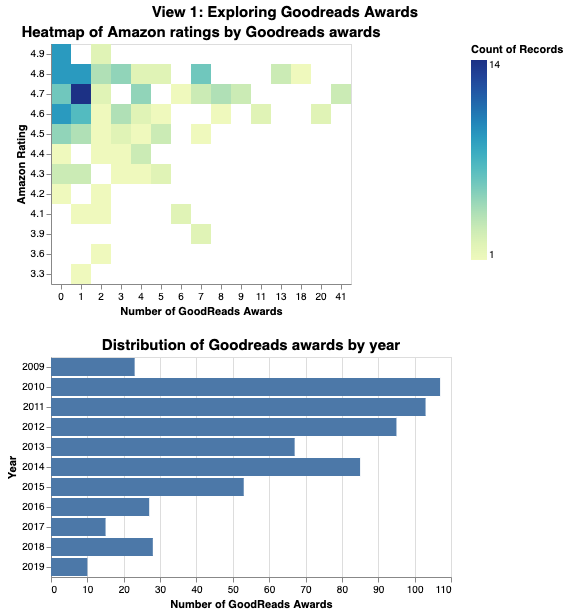

In [13]:
#Click-based interactions 
year = alt.selection_multi(encodings=['y'])
rating = alt.selection_multi(encodings=['y'])

#Heatmap 
v1 = alt.Chart(final).mark_rect().encode(
    alt.Y('amazon_rating:N', sort='-y', title='Amazon Rating'),
    alt.X('goodreads_num_awards:N', title='Number of GoodReads Awards', axis=alt.Axis(labelAngle=-0)),
    alt.Color('count():Q'),
    alt.Tooltip('count()'),
    opacity=alt.condition(rating, alt.value(1), alt.value(0.2)),
).properties(
    selection=rating,
    title = "Heatmap of Amazon ratings by Goodreads awards"
).transform_filter(
    year
)

#Bar chart 
v2 = alt.Chart(final).mark_bar().add_selection(
    year
).encode(
    alt.Y('year:N', title='Year'),
    alt.X('sum(goodreads_num_awards)', title='Number of GoodReads Awards'),
    tooltip=[alt.Tooltip('year', title="Year"), alt.Tooltip('sum(goodreads_num_awards)', title="Total GoodReads Awards")],
    opacity=alt.condition(year, alt.value(1), alt.value(0.2)),
).properties(
    selection=year,
    title = "Distribution of Goodreads awards by year"
).transform_filter(
    rating
)

#Concatenate heatmap and bar chart together
alt.vconcat(v1, v2).properties(
    title = "View 1: Exploring Goodreads Awards"
).configure_title(
    fontSize = 15,
    anchor = 'middle'
)

### 2.3 View 2: Comparing prices between websites

In [14]:
#Create dataframe and clean for view 2
view2_df = final.loc[:,["title","amazon_rating","amazon_price","amazon_genre","goodreads_rating",
                        "goodreads_price","goodreads_genres","nyt_price"]]
view2_df = pd.melt(view2_df, id_vars=['title','goodreads_genres','goodreads_rating','amazon_rating'], value_vars = ["amazon_price","goodreads_price","nyt_price"])
view2_df = view2_df.rename({'value':'price'}, axis=1)
view2_df_exploded = view2_df.explode('goodreads_genres')

In [15]:
#Radio button for choosing 2 prices to compare
price = [['amazon_price','goodreads_price'],['amazon_price','nyt_price'],['goodreads_price','nyt_price']]
radio_button = alt.binding_radio(
    options = price, 
    name    = 'For all charts: Pick 2 websites to compare prices'
)
select_group = alt.selection_single(fields = ['variable'], bind=radio_button)

#Violin plot for 2 chosen prices
price_violin_plot = alt.Chart(view2_df).transform_density(
    'price',
    as_=['price', 'density'],
    groupby=['variable']
).mark_area(orient='horizontal').encode(
    alt.Y('price', title="Price in USD"),
    alt.Color('variable:N', title ="Website"),
    alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
    ),
    column=alt.Column(
        'variable:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
            title = None
        ),
    )
).properties(
    width=150,
    height=250,
    title= ["Price distribution across websites"]
).add_selection(
    select_group
).transform_filter(
    select_group
)

#Dropdown selection for the rating column to display
rating_columns = ['amazon_rating','goodreads_rating']
select_box = alt.binding_select(options=rating_columns, name='Select rating column for bar plot')
sel = alt.selection_single(fields=['column'], bind=select_box, init={'column': 'amazon_rating'}, 
                           clear=False,
                           on="click[event.shiftKey&!event.shiftKey]")
#Bar plot for distribution of rating by price
rating_price_bar = alt.Chart(view2_df.reset_index()).transform_filter(
    select_group
).transform_fold(
    rating_columns,
    as_=['column', 'value']
).transform_filter(
    sel
).mark_bar().encode(
    alt.X('price', bin = alt.BinParams(maxbins=50), title = "Price"),
    alt.Y('value:Q', title="Book rating", scale = alt.Scale(zero=False)),
    alt.Color('variable:N', title = None)
).add_selection(
    sel
).properties(
    width=200,
    height =200,
    title = "Rating distribution by price"
).facet(
    column = 'variable:N'
)

#Dropdown select for filtering by genre
genre_options = list(genre_count.head(10).index)
genre_dropdown = alt.binding_select(options=genre_options, name='Filter price gap plot by popular genres')
select_genre = alt.selection_single(fields = ['goodreads_genres'], bind=genre_dropdown)

#Gap plot for price difference
gap_plot = alt.Chart(view2_df_exploded).transform_filter(
    select_group
).add_selection(
    select_genre
).transform_filter(
    select_genre
)
line = gap_plot.mark_line().encode(
    alt.X('price:Q'),
    alt.Y('title:N',sort='x'),
    detail = 'title'
).properties(
    title= ['Price gap between two chosen websites', ' '],
    width = 300
)
point = alt.Chart(view2_df_exploded).transform_filter(
    select_group
).transform_filter(
    select_genre
).mark_point(
    filled = True
).encode(
    alt.X('price:Q'),
    alt.Y('title',sort='x', title = "Book title"),
    alt.Color('variable:N', title = "Website")
).properties(
    width = 300
)
layer = line + point

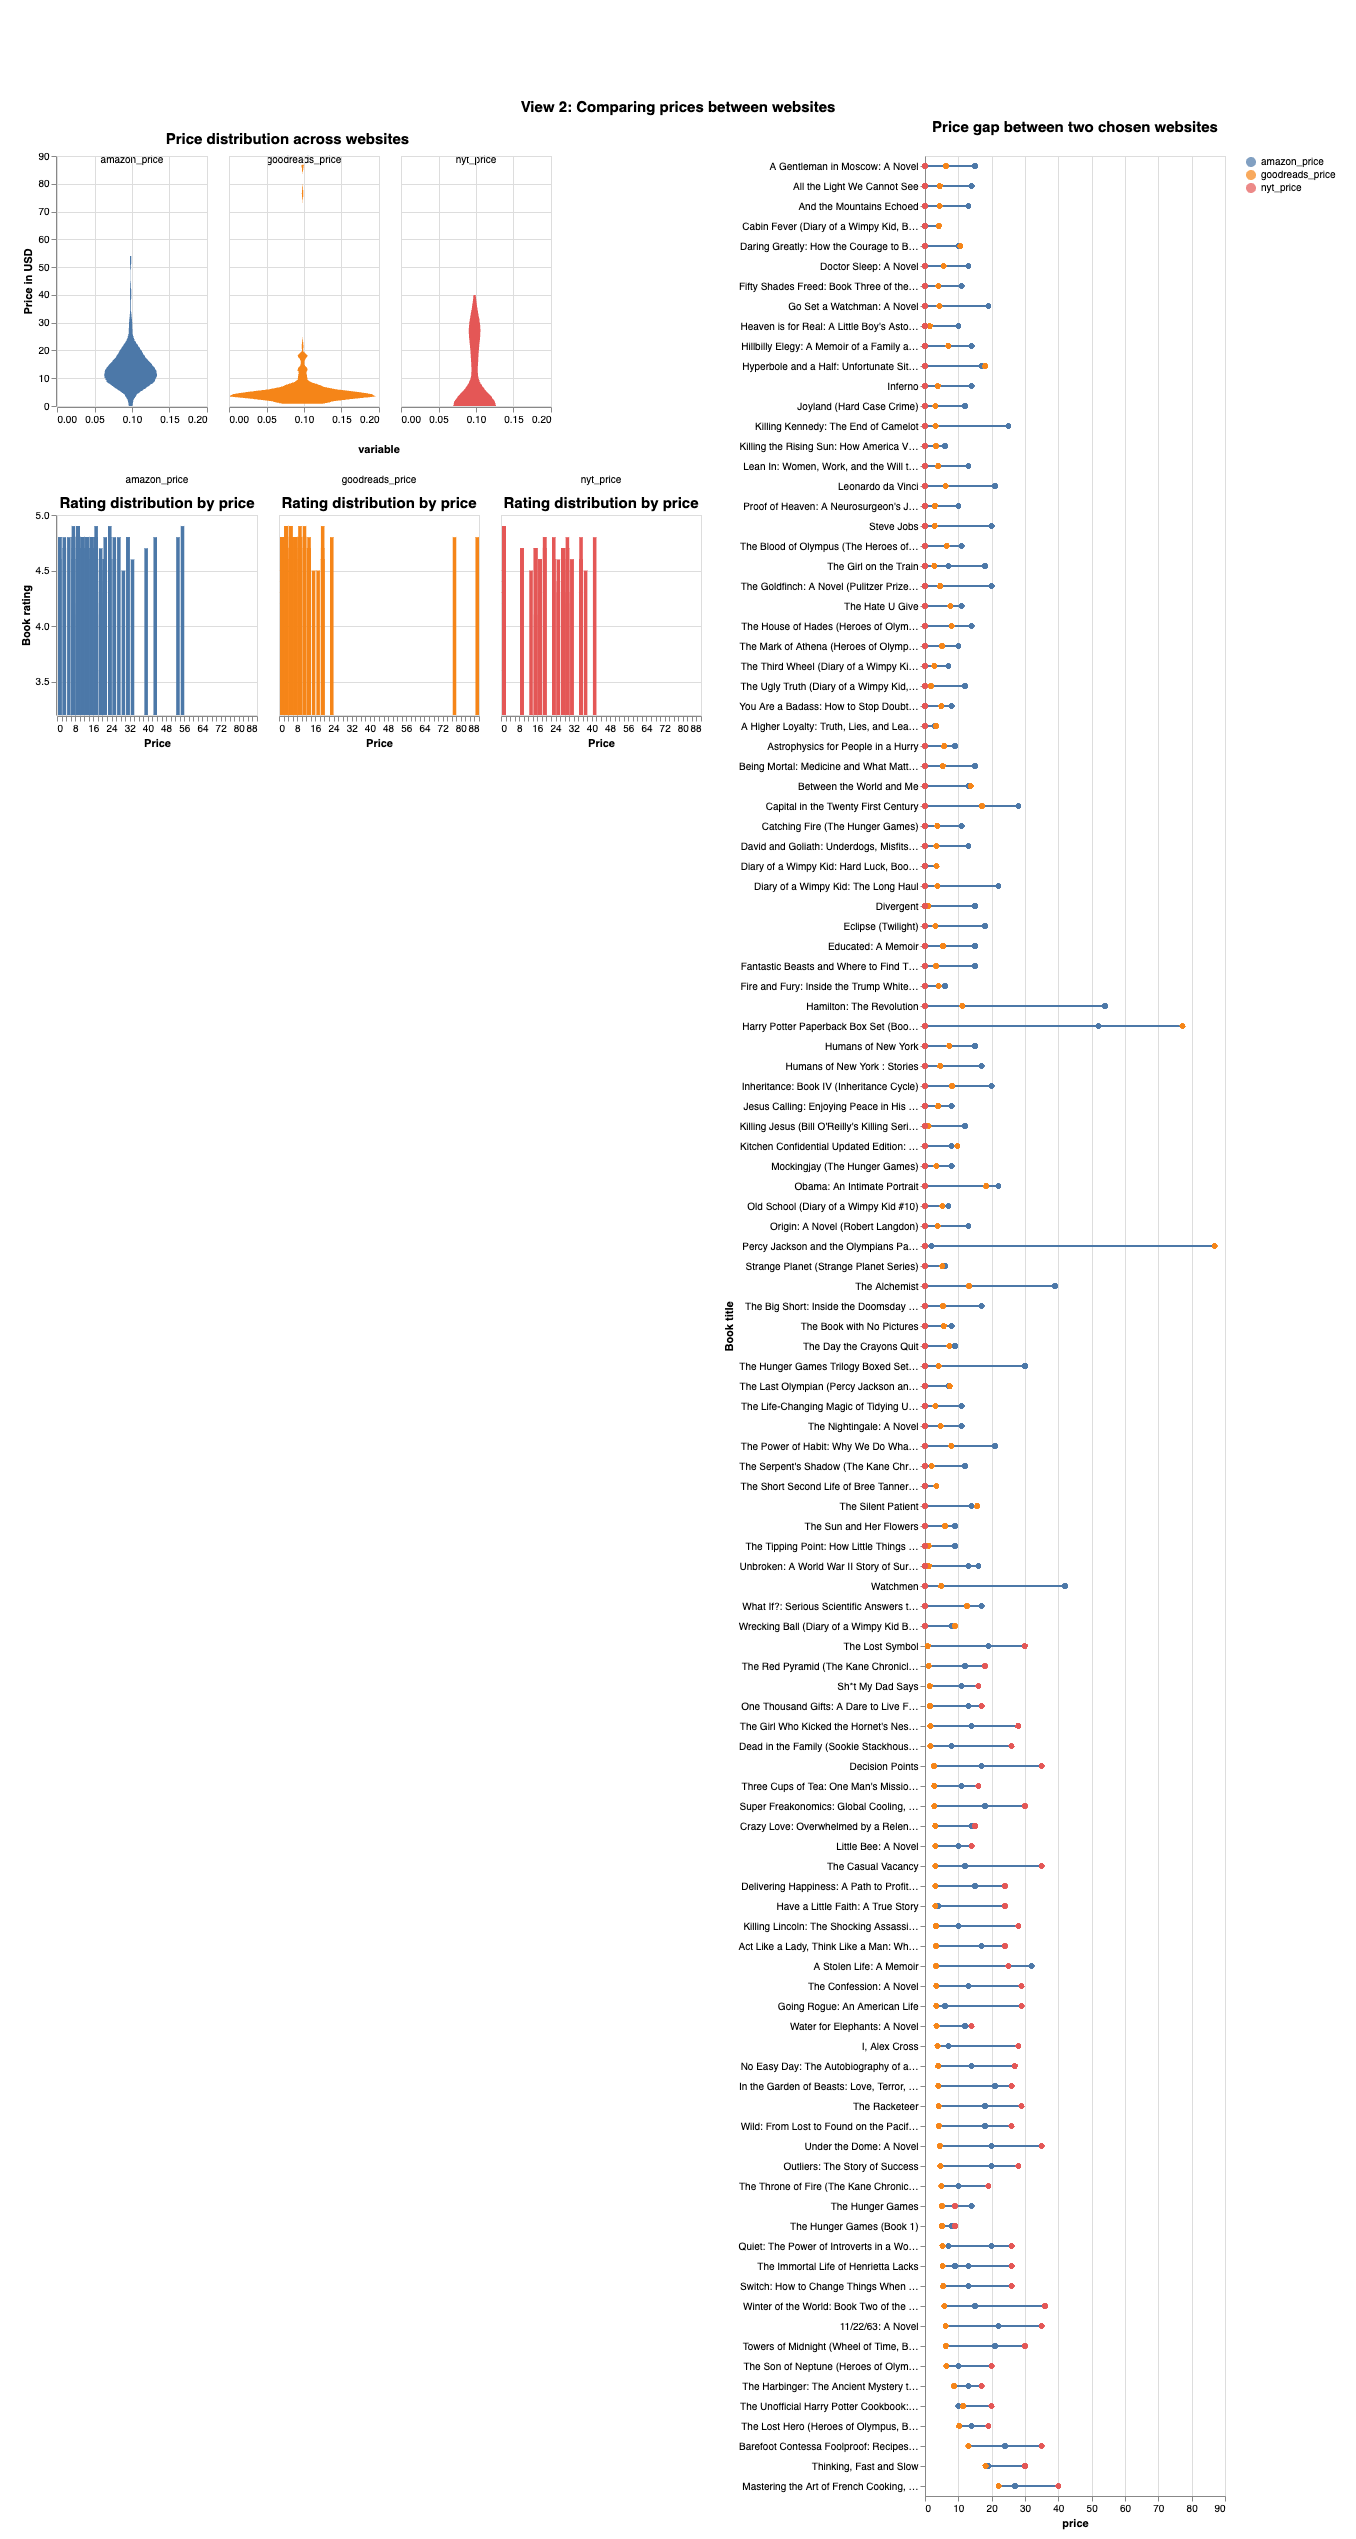

In [16]:
dashboard = alt.vconcat(price_violin_plot, rating_price_bar)
dashboard = alt.hconcat(dashboard, layer, padding={'top': 100, 'bottom': 10, 'left': 20, 'right': 20}).properties(
    title = "View 2: Comparing prices between websites"
).configure_title(
    fontSize = 15, 
    anchor = 'middle'
)
from IPython.display import display, HTML

display(HTML("""
<style>
form.vega-bindings {
    position: absolute;
    top: 0px;
}
</style>
"""))
display(dashboard)

### 2.3 View 3: Exploring number of reviews/ratings

In [17]:
#Explode the goodreads genre row 
view3_df = final.explode('goodreads_genres')

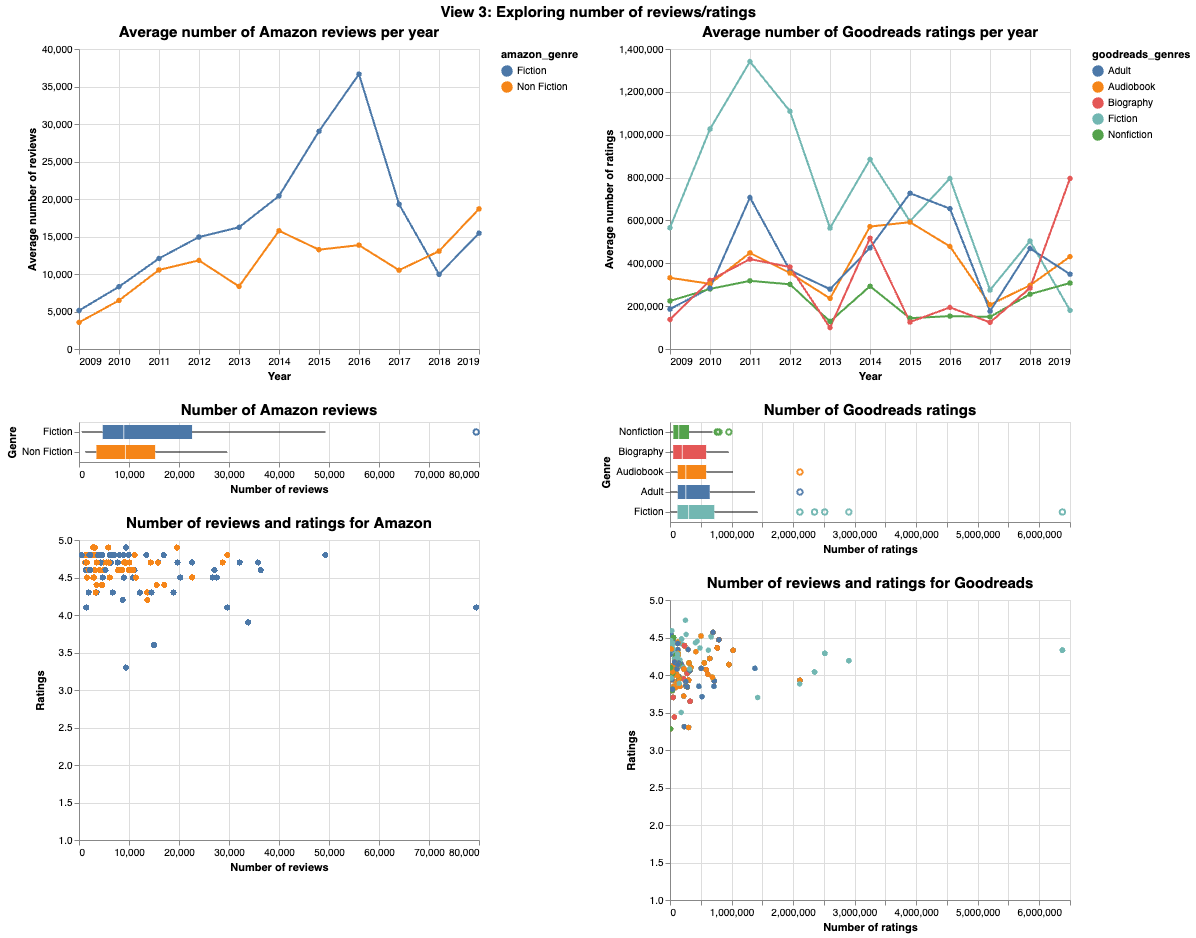

In [18]:
#Legend click interaction for Amazon slope graph 
click = alt.selection_multi(
    fields = ["amazon_genre"], bind = "legend")
         
#Slope graph for Amazon
slope_graph_amazon = alt.Chart(view3_df, 
    title = "Average number of Amazon reviews per year"
    ).mark_line(opacity=0.5, point=True).add_selection(click).encode(
    alt.X('amazon_year:T', title = "Year"),
    alt.Y('mean(amazon_num_reviews):Q', title = "Average number of reviews"),
    alt.Tooltip('mean(amazon_num_reviews):Q', format=",.2f"), 
    alt.Color('amazon_genre:N'), 
    opacity = alt.condition(click, alt.value(1.0), alt.value(0.1))
).properties(
    width={"step": 100} # adjust the step parameter
)

#Legend lick interaction for Goodreads slope graph 
click = alt.selection_multi(
    fields = ["goodreads_genres"], bind = "legend")

#Slope graph for Goodreads
slope_graph_gd =  alt.Chart(view3_df, 
    title = "Average number of Goodreads ratings per year"
    ).mark_line(opacity=0.4, point=True).add_selection(click).encode(
    alt.X('amazon_year:T', title = "Year"),
    alt.Y('mean(goodreads_num_ratings):Q', title = "Average number of ratings"),
    alt.Color('goodreads_genres:N'), 
    alt.Tooltip('mean(goodreads_num_ratings):Q', format=",.2f"), 
    opacity = alt.condition(click, alt.value(1.0), alt.value(0.1))
).properties(
    width={"step": 100} # adjust the step parameter
).transform_filter(
    (datum.goodreads_genres == "Nonfiction") | (datum.goodreads_genres == "Fiction") | (datum.goodreads_genres == "Audiobook") | (datum.goodreads_genres == "Adult") | (datum.goodreads_genres == "Biography")
)

#Boxplot for Amazon
boxplot_amazon = alt.Chart(view3_df, title = "Number of Amazon reviews"
    ).mark_boxplot().encode(
    alt.X("amazon_num_reviews:Q", title = "Number of reviews"),
    alt.Y("amazon_genre:N", title = "Genre", sort = ["Non Fiction", "Fiction"]), 
    alt.Color("amazon_genre:N"))

#CLick based interactions for Amazon boxplot and scatterplot
click = alt.selection_multi(fields = ["amazon_genre"], bind = "legend")
click2 = alt.selection_multi(encodings=['color'])
click3 = alt.selection_multi(fields = ["amazon_genre"], bind = "legend")
click4 = alt.selection_multi(encodings=['color'])

#Bar plot for Amazon to overlay with boxplot
bar_amazon =  alt.Chart(view3_df ,title = "Number of Amazon reviews"
    ).mark_bar().add_selection(click).encode(
    alt.X('amazon_num_reviews:Q', title = "Number of reviews"),
    alt.Y('amazon_genre:N', sort = "-x", title = "Genre"),
    alt.Color('amazon_genre:N'),  
    opacity = alt.condition(click, alt.value(0), alt.value(0)))

#Scatterplot for Amazon
scatterplot_amazon = alt.Chart(view3_df, 
    title = "Number of reviews and ratings for Amazon"
    ).mark_circle().add_selection(click3).encode(
    alt.X("amazon_num_reviews:Q", title = "Number of reviews"), 
    alt.Y("amazon_rating:Q", title = "Ratings", scale = alt.Scale(domain = [1.0, 5.0]), axis=alt.Axis(minExtent=30)), 
    alt.Color("amazon_genre:N"), 
    alt.Tooltip(['amazon_num_reviews:Q', 'amazon_rating:Q', 'title', 'amazon_author']), 
    opacity = alt.condition(click3, alt.value(1.0), alt.value(0.015))).interactive()

#Overlay Amazon boxplot and bar chart together
box_bar_overlay_a = bar_amazon + boxplot_amazon

#Concatenate Amazon scatterplot and boxplot 
box_scatter_a = alt.vconcat(box_bar_overlay_a.add_selection(click2).transform_filter(click4), 
                            scatterplot_amazon.transform_filter(click2).add_selection(click4))

#Boxplot for Goodreads
boxplot_gd = alt.Chart(view3_df, 
    title = "Number of Goodreads ratings").mark_boxplot().add_selection(click).encode(
    alt.X("goodreads_num_ratings:Q", title = "Number of ratings"),
    alt.Y("goodreads_genres:N", title = "Genre", sort = ["Nonfiction", "Biography", "Audiobook", "Adult", "Fiction"]), 
    alt.Color("goodreads_genres:N")).transform_filter(
    (datum.goodreads_genres == "Nonfiction") | (datum.goodreads_genres == "Fiction") | (datum.goodreads_genres == "Audiobook") | (datum.goodreads_genres == "Adult") | (datum.goodreads_genres == "Biography")
)

#Click-based interactions for Goodreads boxplot and scatterplot
click = alt.selection_multi(fields = ["goodreads_genres"], bind = "legend")
click2 = alt.selection_multi(encodings=['color'])
click3 = alt.selection_multi(fields = ["goodreads_genres"], bind = "legend")
click4 = alt.selection_multi(encodings=['color'])

#Bar chart for Goodreads to overlay with boxplot
bar_gd =  alt.Chart(view3_df,title = "Number of Goodreads ratings"
    ).mark_bar().add_selection(click).encode(
    alt.X('goodreads_num_ratings:Q', title = "Number of ratings"),
    alt.Y('goodreads_genres:N', title = "Genre", sort = ["Nonfiction", "Biography", "Audiobook", "Adult", "Fiction"]),
    alt.Color('goodreads_genres:N'),  
    opacity = alt.condition(click, alt.value(0), alt.value(0))).transform_filter(
    (datum.goodreads_genres == "Nonfiction") | (datum.goodreads_genres == "Fiction") | (datum.goodreads_genres == "Audiobook") | (datum.goodreads_genres == "Adult") | (datum.goodreads_genres == "Biography")
)

#Scatterplot for Goodreads
scatterplot_gd = alt.Chart(view3_df, 
    title = "Number of reviews and ratings for Goodreads"
    ).mark_circle().add_selection(click3).encode(
    alt.X("goodreads_num_ratings:Q", title = "Number of ratings"), 
    alt.Y("goodreads_rating:Q", title = "Ratings", scale = alt.Scale(domain = [1.0, 5.0]), axis=alt.Axis(minExtent=30)), 
    alt.Color("goodreads_genres:N"), 
    alt.Tooltip(['goodreads_num_ratings:Q', 'goodreads_rating:Q', 'title', 'amazon_author']), 
    opacity = alt.condition(click3, alt.value(1.0), alt.value(0.01))
).transform_filter(
    (datum.goodreads_genres == "Nonfiction") | (datum.goodreads_genres == "Fiction") | (datum.goodreads_genres == "Audiobook") | (datum.goodreads_genres == "Adult") | (datum.goodreads_genres == "Biography")
).interactive()
    
#Overlay of Goodreads boxplot and bar chart 
box_bar_overlay_gd = bar_gd + boxplot_gd
box_bar_overlay_gd

#Concatenate Goodreads boxplot and scatterplot 
box_scatter_gd = alt.vconcat(box_bar_overlay_gd.add_selection(click2).transform_filter(click4), 
                             scatterplot_gd.transform_filter(click2).add_selection(click4))   

#Add brushing to slope graph and concatenate all visualizations for Amazon together
brush = alt.selection_interval(encodings = ['x'], resolve='intersect')
amazon_multiview = alt.vconcat(slope_graph_amazon.add_selection(brush), 
    box_scatter_a.transform_filter(brush))

#Add brushing to slope graph and concatenate all visualizations for Goodreads together
brush = alt.selection_interval(encodings = ['x'], resolve='intersect')
gd_multiview = alt.vconcat(slope_graph_gd.add_selection(brush), 
    box_scatter_gd.transform_filter(brush))

#Concatenate both Amazon and Goodread visualization into one view 
view3 = alt.hconcat(amazon_multiview, gd_multiview).resolve_scale(
    color='independent'
).properties(
    title = "View 3: Exploring number of reviews/ratings"
).configure_title(
    fontSize = 15,
    anchor = 'middle'
)
view3